In [1]:
import contextily as cx
import geopandas as gpd
import nivapy3 as nivapy
import pandas as pd
from sqlalchemy import text

# Migrate Oracle to PostGIS

This notebook simplifies and cleans the historic data currently in Oracle and transfers it to the Hub's PostGIS database.

In [2]:
# Connect to the NIVABASE
ora_eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


In [3]:
# Connect to Jupyter PostGIS
pg_eng = nivapy.da.connect_postgis(admin=True, host="104.199.55.41")

Username:  ········
Password:  ········


Connection successful.


## 1. Create table structure in PostGIS

In [4]:
# point_source_locations
sql = text("DROP TABLE IF EXISTS teotil3.point_source_locations CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.point_source_locations "
    "( "
    "  site_id text NOT NULL, "
    "  name text NOT NULL, "
    "  type text NOT NULL, "
    "  geom geometry NOT NULL, "
    "  PRIMARY KEY (site_id), "
    "  CONSTRAINT site_unique UNIQUE (site_id, name, type, geom) "
    ")"
)
pg_eng.execute(sql)

# input_param_definitions
sql = text("DROP TABLE IF EXISTS teotil3.input_param_definitions CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.input_param_definitions "
    "( "
    "  in_par_id integer NOT NULL, "
    "  oracle_par_id integer, "
    "  name text NOT NULL, "
    "  unit text NOT NULL, "
    "  comment text, "
    "  PRIMARY KEY (in_par_id), "
    "  CONSTRAINT in_par_unique UNIQUE (in_par_id, name, unit) "
    ")"
)
pg_eng.execute(sql)

# output_param_definitions
sql = text("DROP TABLE IF EXISTS teotil3.output_param_definitions CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.output_param_definitions "
    "( "
    "  out_par_id integer NOT NULL, "
    "  name text NOT NULL, "
    "  unit text NOT NULL, "
    "  PRIMARY KEY (out_par_id), "
    "  CONSTRAINT out_par_unique UNIQUE (out_par_id, name, unit) "
    ")"
)
pg_eng.execute(sql)

# input_output_param_conversion
sql = text("DROP TABLE IF EXISTS teotil3.input_output_param_conversion CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.input_output_param_conversion "
    "( "
    "  in_par_id integer NOT NULL, "
    "  out_par_id integer NOT NULL, "
    "  factor numeric NOT NULL, "
    "  PRIMARY KEY (in_par_id, out_par_id), "
    "  CONSTRAINT in_par_id_fkey FOREIGN KEY (in_par_id) "
    "      REFERENCES teotil3.input_param_definitions (in_par_id), "
    "  CONSTRAINT out_par_id_fkey FOREIGN KEY (out_par_id) "
    "      REFERENCES teotil3.output_param_definitions (out_par_id) "
    ")"
)
pg_eng.execute(sql)

# point_source_values
sql = text("DROP TABLE IF EXISTS teotil3.point_source_values CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.point_source_values "
    "( "
    "  site_id text NOT NULL, "
    "  in_par_id integer NOT NULL, "
    "  year integer NOT NULL, "
    "  value numeric NOT NULL, "
    "  PRIMARY KEY (site_id, in_par_id, year), "
    "  CONSTRAINT site_id_fkey FOREIGN KEY (site_id) "
    "      REFERENCES teotil3.point_source_locations (site_id), "
    "  CONSTRAINT in_par_id_fkey FOREIGN KEY (in_par_id) "
    "      REFERENCES teotil3.input_param_definitions (in_par_id) "
    ")"
)
pg_eng.execute(sql)

# spredt_inputs
sql = text("DROP TABLE IF EXISTS teotil3.spredt_inputs CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.spredt_inputs "
    "( "
    "  komnr text NOT NULL, "
    "  in_par_id integer NOT NULL, "
    "  year integer NOT NULL, "
    "  value numeric NOT NULL, "
    "  PRIMARY KEY (komnr, in_par_id, year), "
    "  CONSTRAINT in_par_id_fkey FOREIGN KEY (in_par_id) "
    "      REFERENCES teotil3.input_param_definitions (in_par_id) "
    ")"
)
pg_eng.execute(sql)

# agri_inputs_teotil2
sql = text("DROP TABLE IF EXISTS teotil3.agri_inputs_teotil2 CASCADE")
pg_eng.execute(sql)

sql = text(
    "CREATE TABLE teotil3.agri_inputs_teotil2 "
    "( "
    "  region text NOT NULL, "
    "  year integer NOT NULL, "
    "  diff_totn_kg numeric NOT NULL, "
    "  point_totn_kg numeric NOT NULL, "
    "  back_totn_kg numeric NOT NULL, "
    "  diff_totp_kg numeric NOT NULL, "
    "  point_totp_kg numeric NOT NULL, "
    "  back_totp_kg numeric NOT NULL, "
    "  PRIMARY KEY (region, year) "
    ")"
)
pg_eng.execute(sql)

## 2. Process data from Oracle

### 2.1. Data for `point_source_locations`

In [5]:
# Get data from Oracle
sql = text(
    "SELECT anlegg_nr AS site_id, "
    "  anlegg_navn AS name, "
    "  type, "
    "  lon_utl AS lon, "
    "  lat_utl AS lat "
    "FROM resa2.rid_punktkilder"
)
pt_df1 = pd.read_sql(sql, ora_eng)

sql = text(
    "SELECT nr AS site_id, "
    "  navn AS name, "
    "  'Aquaculture' AS type, "
    "  bredde AS lon, "
    "  lengde AS lat "
    "FROM resa2.rid_kilder_aquakultur"
)
pt_df2 = pd.read_sql(sql, ora_eng)
pt_df = pd.concat([pt_df1, pt_df2], axis="rows")

pt_df.dropna(how="any", inplace=True)

# Set data types
pt_df["site_id"] = pt_df["site_id"].astype(str)
pt_df["name"] = pt_df["name"].astype(str)
pt_df["type"] = pt_df["type"].astype(str)
pt_df["lon"] = pt_df["lon"].astype(float)
pt_df["lat"] = pt_df["lat"].astype(float)

# Standardise
pt_df["type"].replace(
    {"INDUSTRI": "Industry", "RENSEANLEGG": "Wastewater"}, inplace=True
)
assert set(pt_df["type"]) == set(["Industry", "Wastewater", "Aquaculture"])
assert pt_df["site_id"].is_unique

display(pt_df.head())

nivapy.spatial.quickmap(pt_df, lon_col="lon", lat_col="lat", cluster=True)

site_id                     name      type       lon        lat
0  1146.0006.01            NATURKRAFT AS  Industry  5.517933  59.274471
1  1146.0009.01          STATOIL, Kårstø  Industry  5.512849  59.274733
2  1146.0013.01  Nedstrand Rørmøbler A.S  Industry  5.858138  59.345239
3  1149.0001.01     Karmsund Fiskemel AS  Industry  5.301290  59.336687
4  1149.0006.01       Vigsnes Kobberverk  Industry  5.232516  59.349650

In [6]:
# There are 15 sites off East Africa. Looks like the lat and lon have been switched
pt_df.set_index("site_id", inplace=True)
switch_df = pt_df.query("lat < 50").copy()
switch_df

name         type        lon        lat
site_id                                           
33218    Ukjent  Aquaculture  64.085667   9.883383
33077    Ukjent  Aquaculture  61.206000   5.131733
33097    Ukjent  Aquaculture  70.043750  20.949650
33477    Ukjent  Aquaculture  68.772833  15.446583
32577    Ukjent  Aquaculture  60.081650   5.168567
33517    Ukjent  Aquaculture  70.817200  24.590567
30196    Ukjent  Aquaculture  60.832500   5.356067
33177    Ukjent  Aquaculture  63.939900   9.885750
33537    Ukjent  Aquaculture  64.156900  10.008917
33017    Ukjent  Aquaculture  62.738350   6.937667
32037    Ukjent  Aquaculture  66.348733  12.779417
33157    Ukjent  Aquaculture  65.831417  12.070533
32197    Ukjent  Aquaculture  62.644400   6.556800
23436    Ukjent  Aquaculture  61.206250   4.936283
32697    Ukjent  Aquaculture  68.511850  14.951633

In [7]:
# Switch co-ords for these stations
pt_df.loc[switch_df.index, "lon"] = switch_df["lat"]
pt_df.loc[switch_df.index, "lat"] = switch_df["lon"]
display(pt_df.loc[switch_df.index])
pt_df.reset_index(inplace=True)
nivapy.spatial.quickmap(
    pt_df, lon_col="lon", lat_col="lat", cluster=True, popup="site_id"
)

name         type        lon        lat
site_id                                           
33218    Ukjent  Aquaculture   9.883383  64.085667
33077    Ukjent  Aquaculture   5.131733  61.206000
33097    Ukjent  Aquaculture  20.949650  70.043750
33477    Ukjent  Aquaculture  15.446583  68.772833
32577    Ukjent  Aquaculture   5.168567  60.081650
33517    Ukjent  Aquaculture  24.590567  70.817200
30196    Ukjent  Aquaculture   5.356067  60.832500
33177    Ukjent  Aquaculture   9.885750  63.939900
33537    Ukjent  Aquaculture  10.008917  64.156900
33017    Ukjent  Aquaculture   6.937667  62.738350
32037    Ukjent  Aquaculture  12.779417  66.348733
33157    Ukjent  Aquaculture  12.070533  65.831417
32197    Ukjent  Aquaculture   6.556800  62.644400
23436    Ukjent  Aquaculture   4.936283  61.206250
32697    Ukjent  Aquaculture  14.951633  68.511850

site_id                     name      type                  geometry
0  1146.0006.01            NATURKRAFT AS  Industry  POINT (5.51793 59.27447)
1  1146.0009.01          STATOIL, Kårstø  Industry  POINT (5.51285 59.27473)
2  1146.0013.01  Nedstrand Rørmøbler A.S  Industry  POINT (5.85814 59.34524)
3  1149.0001.01     Karmsund Fiskemel AS  Industry  POINT (5.30129 59.33669)
4  1149.0006.01       Vigsnes Kobberverk  Industry  POINT (5.23252 59.34965)

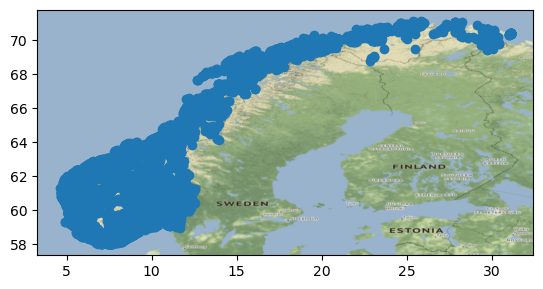

In [8]:
# 3 points are mistakenly placed in the deep ocean => remove these.
to_drop = ["1744.0011.03", "11757", "13769"]
pt_df = pt_df.query("site_id not in @to_drop")

# Also some sites on Svalbard which we don't need for TEOTIL
pt_df = pt_df.query("lat < 72")

# Build geodataframe
pt_gdf = gpd.GeoDataFrame(
    pt_df, geometry=gpd.points_from_xy(pt_df["lon"], pt_df["lat"], crs="epsg:4326")
)
del pt_gdf["lon"], pt_gdf["lat"]
display(pt_gdf.head())

ax = pt_gdf.plot()
cx.add_basemap(ax, crs=pt_gdf.crs.to_string(), attribution=False)

In [9]:
table_name = "point_source_locations"

nivapy.da.gdf_to_postgis(
    pt_gdf,
    table_name,
    "teotil3",
    pg_eng,
    f"{table_name}_spidx",
    create_pk=False,
    index=False,
    if_exists="append",
)

### 2.2. Parameter definitions

In [10]:
# input_param_definitions
csv_path = r"../../data/postgis_input_parameter_definitions.csv"
df = pd.read_csv(csv_path)
df.to_sql(
    "input_param_definitions", pg_eng, schema="teotil3", index=False, if_exists="append"
)

# output_param_definitions
csv_path = r"../../data/postgis_output_parameter_definitions.csv"
df = pd.read_csv(csv_path)
df.to_sql(
    "output_param_definitions",
    pg_eng,
    schema="teotil3",
    index=False,
    if_exists="append",
)

# input_output_param_conversion
csv_path = r"../../data/postgis_input_output_param_conversion.csv"
df = pd.read_csv(csv_path)
df.to_sql(
    "input_output_param_conversion",
    pg_eng,
    schema="teotil3",
    index=False,
    if_exists="append",
)

104

### 2.3. Agricultural inputs for TEOTIL2

In [11]:
sql = text(
    "SELECT omrade AS region, "
    "  year, "
    "  n_diff_kg AS diff_totn_kg, "
    "  n_point_kg AS point_totn_kg, "
    "  n_back_kg AS back_totn_kg, "
    "  p_diff_kg AS diff_totp_kg, "
    "  p_point_kg AS point_totp_kg, "
    "  p_back_kg AS back_totp_kg "
    "FROM resa2.rid_agri_inputs "
    "order by year, region"
)
df = pd.read_sql(sql, ora_eng)
df.head()

region  year  diff_totn_kg  point_totn_kg  back_totn_kg  diff_totp_kg  \
0   aag1  1990        130092              0         18097          3361   
1   aag2  1990        241613              0         53366          6471   
2   ake1  1990       2017962              0        237631        113588   
3   ake2  1990        892992              0        117703         34423   
4   ake3  1990        232920              0         39791          9899   

   point_totp_kg  back_totp_kg  
0              0           465  
1              0           800  
2              0          5703  
3              0          2221  
4              0           873

In [12]:
df.to_sql(
    "agri_inputs_teotil2",
    pg_eng,
    schema="teotil3",
    index=False,
    if_exists="append",
)

333

### 2.4. Spredt

In [13]:
sql = text(
    "SELECT komm_no AS komnr, "
    "  inp_par_id as in_par_id, "
    "  ar AS year, "
    "  value "
    "FROM resa2.rid_kilder_spredt_values "
    "order by year, komnr, in_par_id"
)
df = pd.read_sql(sql, ora_eng)

# Remap par_ids to match PostGIS
assert set(df["in_par_id"]) == set([44, 45])
df["in_par_id"].replace({44: 34, 45: 37}, inplace=True)

df.head()

komnr  in_par_id  year   value
0  0101         34  1993  9258.0
1  0101         37  1993  1170.0
2  0104         34  1993  2085.0
3  0104         37  1993   210.0
4  0105         34  1993  5363.0

In [14]:
df.to_sql(
    "spredt_inputs",
    pg_eng,
    schema="teotil3",
    index=False,
    if_exists="append",
)

862

## 2.5. Point source values

In [15]:
# Read data from Oracle
sql = text(
    "SELECT anlegg_nr AS site_id, "
    "  inp_par_id as in_par_id, "
    "  year, "
    "  value "
    "FROM resa2.rid_punktkilder_inpar_values "
    "order by year, site_id, in_par_id"
)
df = pd.read_sql(sql, ora_eng)

# Remap par_ids to match PostGIS
sql = text(
    "SELECT in_par_id, oracle_par_id "
    "FROM teotil3.input_param_definitions "
    "WHERE oracle_par_id IS NOT NULL"
)
remap_df = pd.read_sql(sql, pg_eng)
remap_dict = remap_df.set_index("oracle_par_id").to_dict()["in_par_id"]
ora_id_list = remap_df["oracle_par_id"].tolist()
df = df.query("in_par_id in @ora_id_list")
df["in_par_id"].replace(remap_dict, inplace=True)

# Remove data for sites with invalid locations
sql = text("SELECT site_id FROM teotil3.point_source_locations")
site_df = pd.read_sql(sql, pg_eng)
site_list = site_df["site_id"].tolist()
df = df.query("site_id in @site_list")

df.head()

site_id  in_par_id  year    value
0  0101.0031.01         43  1990  26776.0
1  0101.0031.01         77  1990     62.0
2  0101.0031.01         90  1990     15.8
3  0101.0031.01         95  1990   1575.0
4  0101.0047.01         82  1990     10.0

In [16]:
df.to_sql(
    "point_source_values",
    pg_eng,
    schema="teotil3",
    index=False,
    if_exists="append",
)

26